In [ ]:
Leer archivos .fasta de la carpeta entrada_genomas/

In [15]:
import os
import glob

# Rutas adaptadas
ruta_fasta = "/home/alumno08/TFM/fase2/phagetax/entrada_genomas"
ruta_salida = "/home/alumno08/TFM/fase2/phagetax/pharokka_out"

# Listar todos los archivos .fasta
ficheros_fasta = glob.glob(os.path.join(ruta_fasta, "*.fasta"))
print(f"Se han encontrado {len(ficheros_fasta)} archivos .fasta")

# Identificar genomas que aún no están anotados
genomas_por_anotar = []
for fasta in ficheros_fasta:
    nombre = os.path.splitext(os.path.basename(fasta))[0]
    carpeta_salida = os.path.join(ruta_salida, nombre)
    if not os.path.exists(carpeta_salida):
        genomas_por_anotar.append((nombre, fasta))

print(f"{len(genomas_por_anotar)} genomas necesitan anotación:")
for nombre, _ in genomas_por_anotar:
    print(f" - {nombre}")

Se han encontrado 6 archivos .fasta
1 genomas necesitan anotación:
 - T4


In [ ]:
Ejecutar Pharokka sobre los genomas pendientes

In [16]:
%%bash

# Activar entorno conda y lanzar Pharokka exactamente como en tu script
source ~/.bashrc
conda activate pharokka-env

# Rutas
INPUT_DIR="/home/alumno08/TFM/fase2/phagetax/entrada_genomas"
OUTPUT_DIR="/home/alumno08/TFM/fase2/phagetax/pharokka_out"
DB_DIR="/home/alumno08/miniconda3/envs/pharokka-env/bin/databases"
PHAROKKA="/home/alumno08/miniconda3/envs/pharokka-env/bin/pharokka.py"

# Crear carpeta de salida si no existe
mkdir -p "$OUTPUT_DIR"

# Iterar sobre cada genoma
for file in "$INPUT_DIR"/*.fasta; do
    base=$(basename "$file" .fasta)
    
    if [ -d "$OUTPUT_DIR/$base" ]; then
        echo " $base ya anotado. Saltando..."
        continue
    fi

    echo "Anotando $base..."
    /home/alumno08/miniconda3/envs/pharokka-env/bin/python "$PHAROKKA" -i "$file" -o "$OUTPUT_DIR/$base" -d "$DB_DIR" -t 4 -f
done

echo "Anotación completa. Resultados guardados en $OUTPUT_DIR."

 Cellulophaga ya anotado. Saltando...
 CPG1g ya anotado. Saltando...
 crp13 ya anotado. Saltando...
 P22 ya anotado. Saltando...
 sio2 ya anotado. Saltando...
Anotando T4...


/home/alumno08/miniconda3/envs/pharokka-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/alumno08/miniconda3/envs/pharokka-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/alumno08/miniconda3/envs/pharokka-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/alumno08/miniconda3/envs/pharokka-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
2025-07-06 11:

Anotación completa. Resultados guardados en /home/alumno08/TFM/fase2/phagetax/pharokka_out.


In [ ]:
Construcción de la matriz binaria

In [17]:
import os
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Rutas
# -----------------------------
PHAROKKA_OUT = "/home/alumno08/TFM/fase2/phagetax/pharokka_out"
OUTFILE = "/home/alumno08/TFM/fase2/phagetax/df_phrogs_binaria.tsv"

# -----------------------------
# Leer genomas anotados, excluyendo carpetas ocultas
# -----------------------------
genomas_anotados = sorted([
    d for d in os.listdir(PHAROKKA_OUT)
    if os.path.isdir(os.path.join(PHAROKKA_OUT, d)) and not d.startswith(".")
])

phrog_dict = {}

for genoma_id in tqdm(genomas_anotados, desc="Procesando genomas anotados"):
    phrog_file = os.path.join(PHAROKKA_OUT, genoma_id, "pharokka_cds_final_merged_output.tsv")
    try:
        df_phrog = pd.read_csv(phrog_file, sep="\t")
        if "phrog" not in df_phrog.columns:
            raise ValueError("La columna 'phrog' no está en el archivo.")
        
        phrogs = df_phrog["phrog"].dropna().unique()
        phrogs = [str(p).strip().replace("phrog_", "") for p in phrogs if isinstance(p, str) and p != "No_PHROG"]
        phrog_dict[genoma_id] = phrogs

    except Exception as e:
        print(f"Error leyendo PHROGs en {genoma_id}: {e}")
        phrog_dict[genoma_id] = []

# -----------------------------
# Obtener PHROGs únicos limpios
# -----------------------------
phrogs_unicos = sorted(set(
    phrog for lista in phrog_dict.values() for phrog in lista if isinstance(phrog, str)
))

# -----------------------------
# Crear DataFrame binario
# -----------------------------
df_bin = pd.DataFrame(0, index=genomas_anotados, columns=[f"PHROG_{p}" for p in phrogs_unicos])

for genoma_id, lista in phrog_dict.items():
    for phrog in lista:
        col = f"PHROG_{phrog}"
        if col in df_bin.columns:
            df_bin.at[genoma_id, col] = 1

# -----------------------------
# Guardar matriz
# -----------------------------
df_bin.to_csv(OUTFILE, sep="\t")
print(f" Matriz binaria guardada correctamente en: {OUTFILE}")

Procesando genomas anotados: 100%|██████████| 8/8 [00:00<00:00, 334.84it/s]

 Matriz binaria guardada correctamente en: /home/alumno08/TFM/fase2/phagetax/df_phrogs_binaria.tsv


In [ ]:
Construcción de la matriz con taxonomía e información genómica

In [18]:
import os
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Rutas
# -----------------------------
PHAROKKA_OUT = "/home/alumno08/TFM/fase2/phagetax/pharokka_out"
RESUMEN_PATH = "/home/alumno08/TFM/fase2/phagetax/matriz_phrogs_tax_gc_simple.tsv"

# -----------------------------
# Procesar genomas
# -----------------------------
genomas = sorted([
    d for d in os.listdir(PHAROKKA_OUT)
    if os.path.isdir(os.path.join(PHAROKKA_OUT, d)) and not d.startswith(".")
])

info_data = []

for genoma in tqdm(genomas, desc="Extrayendo información genómica"):
    resumen_path = os.path.join(PHAROKKA_OUT, genoma, "pharokka_length_gc_cds_density.tsv")
    phrog_path = os.path.join(PHAROKKA_OUT, genoma, "pharokka_cds_final_merged_output.tsv")
    
    try:
        resumen_df = pd.read_csv(resumen_path, sep="\t")
        length = resumen_df["length"].iloc[0]
        gc_perc = resumen_df["gc_perc"].iloc[0]
        
        if os.path.exists(phrog_path):
            genes_df = pd.read_csv(phrog_path, sep="\t")
            num_genes = genes_df.shape[0]
        else:
            num_genes = 0

        info_data.append({
            "genome_id": genoma,
            "genome_length": length,
            "gc_percent": gc_perc,
            "num_genes": num_genes
        })
    except Exception as e:
        print(f"Error en {genoma}: {e}")

# -----------------------------
# Guardar resumen
# -----------------------------
df_info = pd.DataFrame(info_data).set_index("genome_id")
df_info.to_csv(RESUMEN_PATH, sep="\t")
print(f" Tabla taxonómica e información genómica guardada en {RESUMEN_PATH}")

Extrayendo información genómica: 100%|██████████| 8/8 [00:00<00:00, 297.44it/s]

 Tabla taxonómica e información genómica guardada en /home/alumno08/TFM/fase2/phagetax/matriz_phrogs_tax_gc_simple.tsv


In [ ]:
Combinación de las matrices

In [19]:
import pandas as pd
import os

# -----------------------------
# Rutas
# -----------------------------
ruta_binaria = "/home/alumno08/TFM/fase2/phagetax/df_phrogs_binaria.tsv"
ruta_pharokka = "/home/alumno08/TFM/fase2/phagetax/matriz_phrogs_tax_gc_simple.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_salida = "/home/alumno08/TFM/fase2/phagetax/matriz_phrogs_tax_gc_final.tsv"

niveles_tax = ["Kingdom", "Phylum", "Class", "Family", "Genus", "Species"]

# -----------------------------
# Cargar matrices
# -----------------------------
df_bin = pd.read_csv(ruta_binaria, sep="\t", index_col=0)
df_pharokka = pd.read_csv(ruta_pharokka, sep="\t", index_col=0)

# -----------------------------
# Combinar PHROGs de Pharokka sobre la matriz binaria
# -----------------------------
phrog_cols = [col for col in df_bin.columns if col.startswith("PHROG_")]

for col in phrog_cols:
    if col in df_pharokka.columns:
        df_bin[col] = df_bin[col] | df_pharokka[col]

# -----------------------------
# Reconstruir tabla completa (taxonomía + PHROGs)
# -----------------------------
phrog_cols_pharokka = [col for col in df_pharokka.columns if col.startswith("PHROG_")]
df_tax_gc = df_pharokka.drop(columns=phrog_cols_pharokka)

df_final = df_tax_gc.join(df_bin, how="outer").fillna(0)

# -----------------------------
# Generar caracteristicos_* y especificos_*
# -----------------------------
phrogs_especificos = {nivel: pd.read_csv(f"{ruta_phrogs}/phrogs_especificos_por_{nivel.lower()}.tsv", sep="\t") for nivel in niveles_tax}
phrogs_caracteristicos = {nivel: pd.read_csv(f"{ruta_phrogs}/phrogs_caracteristicos_por_{nivel.lower()}.tsv", sep="\t") for nivel in niveles_tax}

phrog_cols_final = [col for col in df_final.columns if col.startswith("PHROG_")]
df_extra = pd.DataFrame(index=df_final.index)

for nivel in niveles_tax:
    df_esp = phrogs_especificos[nivel]
    df_carac = phrogs_caracteristicos[nivel]

    num_esp = []
    num_carac = []

    for idx, fila in df_final.iterrows():
        presentes = fila[phrog_cols_final][fila[phrog_cols_final] == 1].index.tolist()

        phrogs_esp_total = []
        phrogs_carac_total = []

        for col in df_esp.columns:
            phrogs_esp_total.extend(df_esp[col].dropna().tolist())
        for col in df_carac.columns:
            phrogs_carac_total.extend(df_carac[col].dropna().tolist())

        n_esp = 3 * len(set(presentes) & set(phrogs_esp_total))
        n_carac = len(set(presentes) & set(phrogs_carac_total))

        num_esp.append(n_esp)
        num_carac.append(n_carac)

    df_extra[f"especificos_{nivel.lower()}"] = num_esp
    df_extra[f"caracteristicos_{nivel.lower()}"] = num_carac

# -----------------------------
# Guardar matriz final
# -----------------------------
df_final = pd.concat([df_final, df_extra], axis=1)
df_final.to_csv(ruta_salida, sep="\t")

print(f" Matriz final combinada y corregida guardada en {ruta_salida}")

/tmp/ipykernel_3079995/2122589143.py:41: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,26

 Matriz final combinada y corregida guardada en /home/alumno08/TFM/fase2/phagetax/matriz_phrogs_tax_gc_final.tsv


In [ ]:
Aplicación de los modelos predictivos y obtención de info con métricas y avisos

In [20]:
import pandas as pd
import pickle
import os

# -----------------------------
# Rutas
# -----------------------------
ruta_matriz = "/home/alumno08/TFM/fase2/phagetax/matriz_phrogs_tax_gc_final.tsv"
ruta_modelos = "/home/alumno08/TFM/fase2/10_modelo_final_por_nivel"
ruta_salida = "/home/alumno08/TFM/fase2/phagetax/predicciones_nuevos.tsv"

niveles_tax = ["Kingdom", "Phylum", "Class", "Family", "Genus", "Species"]

# -----------------------------
# Cargar matriz final
# -----------------------------
df = pd.read_csv(ruta_matriz, sep="\t", index_col=0)

# -----------------------------
# Aplicar modelos por nivel
# -----------------------------
resultados = pd.DataFrame(index=df.index)

for nivel in niveles_tax:
    
    print(f"\n Procesando nivel {nivel}...")

    # Cargar modelo
    with open(os.path.join(ruta_modelos, f"modelo_{nivel.lower()}.pkl"), "rb") as f:
        modelo = pickle.load(f)

    # Extraer columnas que el modelo espera
    columnas_usadas = modelo.feature_names_in_.tolist()

    columnas_presentes = [col for col in columnas_usadas if col in df.columns]
    columnas_faltantes = [col for col in columnas_usadas if col not in df.columns]

    df_filtrado = df[columnas_presentes].copy()
    df_faltantes = pd.DataFrame(0, index=df.index, columns=columnas_faltantes)

    df_completo = pd.concat([df_filtrado, df_faltantes], axis=1)
    df_completo = df_completo[columnas_usadas]  # Orden correcto

    # Predicción
    predicciones = modelo.predict(df_completo)
    probs = modelo.predict_proba(df_completo)

    prob_predicha = []
    clases = modelo.classes_

    for pred, prob_vector in zip(predicciones, probs):
        idx_clase = list(clases).index(pred)
        prob_predicha.append(prob_vector[idx_clase])

    resultados[nivel] = predicciones
    resultados[f"Confianza_{nivel}"] = prob_predicha

# -----------------------------
# Guardar resultados
# -----------------------------
resultados.to_csv(ruta_salida, sep="\t")
print(f"\n Predicciones guardadas en: {ruta_salida}")


 Procesando nivel Kingdom...

 Procesando nivel Phylum...

 Procesando nivel Class...

 Procesando nivel Family...

 Procesando nivel Genus...

 Procesando nivel Species...

 Predicciones guardadas en: /home/alumno08/TFM/fase2/phagetax/predicciones_nuevos.tsv


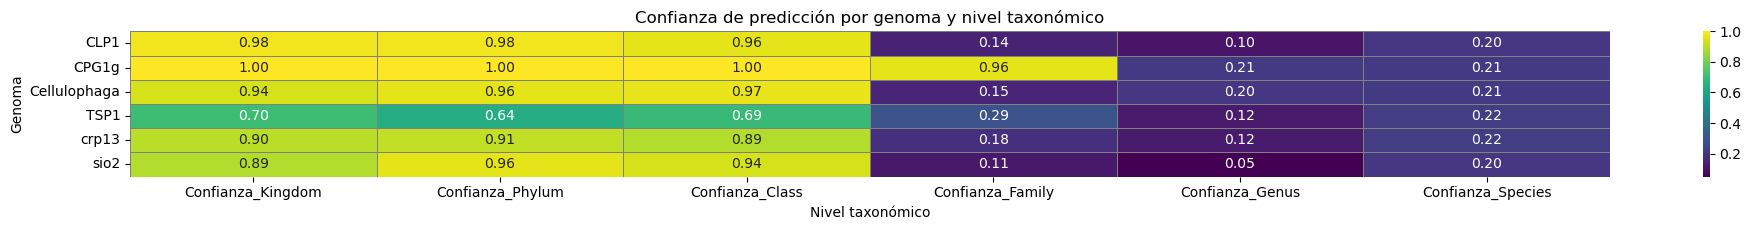

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Cargar predicciones
# -----------------------------
ruta_predicciones = "/home/alumno08/TFM/fase2/phagetax/predicciones_nuevos.tsv"
df_pred = pd.read_csv(ruta_predicciones, sep="\t", index_col=0)

# -----------------------------
# Preparar matriz de confianzas
# -----------------------------
niveles_tax = ["Kingdom", "Phylum", "Class", "Family", "Genus", "Species"]
matriz_confianza = df_pred[[f"Confianza_{nivel}" for nivel in niveles_tax]].copy()

# -----------------------------
# Crear heatmap bonito
# -----------------------------
plt.figure(figsize=(20, 0.4 * len(df_pred)))
sns.heatmap(matriz_confianza, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5, linecolor='gray')
plt.title("Confianza de predicción por genoma y nivel taxonómico")
plt.xlabel("Nivel taxonómico")
plt.ylabel("Genoma")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3079995/552357712.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


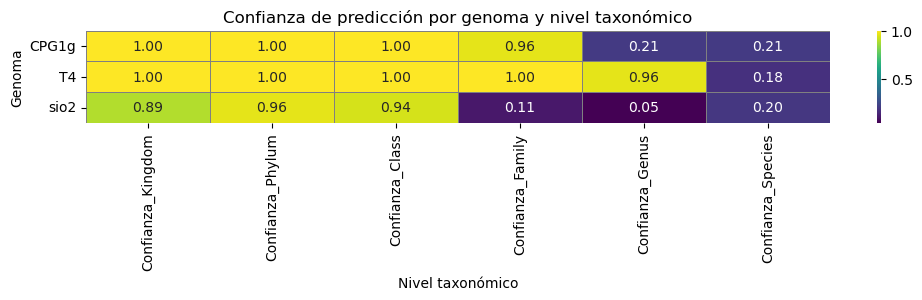

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Cargar predicciones
# -----------------------------
ruta_predicciones = "/home/alumno08/TFM/fase2/phagetax/predicciones_nuevos.tsv"
df_pred = pd.read_csv(ruta_predicciones, sep="\t", index_col=0)

# -----------------------------
# Excluir genomas y renombrar
# -----------------------------
df_pred = df_pred[~df_pred.index.isin(["TSP1", "CLP1", "Cellulophaga", "crp13", "P22"])]

# -----------------------------
# Preparar matriz de confianzas
# -----------------------------
niveles_tax = ["Kingdom", "Phylum", "Class", "Family", "Genus", "Species"]
matriz_confianza = df_pred[[f"Confianza_{nivel}" for nivel in niveles_tax]].copy()

# -----------------------------
# Crear heatmap bonito
# -----------------------------
plt.figure(figsize=(12, 0.4 * len(df_pred)))
sns.heatmap(matriz_confianza, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5, linecolor='gray')
plt.title("Confianza de predicción por genoma y nivel taxonómico")
plt.xlabel("Nivel taxonómico")
plt.ylabel("Genoma")
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import os

# -----------------------------
# Rutas
# -----------------------------
ruta_matriz = "/home/alumno08/TFM/fase2/phagetax/matriz_phrogs_tax_gc_final.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_salida = "/home/alumno08/TFM/fase2/phagetax/phrogs_presentes_por_genoma.tsv"

niveles_tax = ["Kingdom", "Phylum", "Class", "Family", "Genus", "Species"]

# -----------------------------
# Cargar matriz final
# -----------------------------
df = pd.read_csv(ruta_matriz, sep="\t", index_col=0)
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]

# -----------------------------
# Cargar listas de PHROGs específicos y característicos
# -----------------------------
phrogs_especificos = {nivel: pd.read_csv(f"{ruta_phrogs}/phrogs_especificos_por_{nivel.lower()}.tsv", sep="\t") for nivel in niveles_tax}
phrogs_caracteristicos = {nivel: pd.read_csv(f"{ruta_phrogs}/phrogs_caracteristicos_por_{nivel.lower()}.tsv", sep="\t") for nivel in niveles_tax}

# -----------------------------
# Recuento y listado de PHROGs presentes
# -----------------------------
datos = []

for idx, fila in df.iterrows():
    presentes = fila[phrog_cols][fila[phrog_cols] == 1].index.tolist()
    
    info_genoma = {"Genoma": idx}
    
    for nivel in niveles_tax:
        df_esp = phrogs_especificos[nivel]
        df_carac = phrogs_caracteristicos[nivel]

        phrogs_esp_total = []
        phrogs_carac_total = []

        for col in df_esp.columns:
            phrogs_esp_total.extend(df_esp[col].dropna().tolist())
        for col in df_carac.columns:
            phrogs_carac_total.extend(df_carac[col].dropna().tolist())

        presentes_esp = sorted(set(presentes) & set(phrogs_esp_total))
        presentes_carac = sorted(set(presentes) & set(phrogs_carac_total))

        info_genoma[f"PHROGs_especificos_{nivel}"] = ";".join(presentes_esp) if presentes_esp else "Ninguno"
        info_genoma[f"PHROGs_caracteristicos_{nivel}"] = ";".join(presentes_carac) if presentes_carac else "Ninguno"
    
    datos.append(info_genoma)

# -----------------------------
# Guardar resultados
# -----------------------------
df_resultado = pd.DataFrame(datos).set_index("Genoma")
df_resultado.to_csv(ruta_salida, sep="\t")

print(f" PHROGs presentes por genoma guardados en: {ruta_salida}")

/tmp/ipykernel_3079995/487479607.py:23: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261

 PHROGs presentes por genoma guardados en: /home/alumno08/TFM/fase2/phagetax/phrogs_presentes_por_genoma.tsv


In [14]:
import pandas as pd

# Ruta del archivo
ruta = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"

# Cargar la tabla
df = pd.read_csv(ruta, sep="\t", index_col=0)

# Filtrar por Species
tequatrovirus = df[df["Species"] == "Tequatrovirus"]

# Mostrar resultados
print(f"Número de genomas con Species 'tequatrovirus': {tequatrovirus.shape[0]}")

/tmp/ipykernel_3079995/3717136536.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta, sep="\t", index_col=0)


Número de genomas con Species 'tequatrovirus': 0
